# Example

The following example demonstrates how to the use the `pymatch` package to match [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data). Follow the link to download the dataset from Kaggle (you'll have to create an account, it's fast and free!).

Here we match Lending Club users that fully paid off loans (control) to those that defaulted (test). A use case for this could be that we want to analyze user sentiment with the platform. Users that default may have worse sentiment because they are predisposed to a bad situation--influencing their perception of the product. Before analyzing sentiment, we can match users that paid their loans in full to users that defaulted based on the characteristics we observe. If matching is successful, we could then make a statetment about the **causal effect** defaulting has on sentiment if we are confident our samples are sufficiently balanced and our model is free from omitted variable bias.

----

### Data Prep

In [2]:
import warnings
warnings.filterwarnings('ignore')
from pymatch.matcher import Matcher
import pandas as pd
import numpy as np

%matplotlib inline

Load the dataset and select a subset of columns.


In [3]:
data = pd.read_csv("/Users/bmiroglio/Downloads/lending-club-loan-data/loan.csv")\
        [[
            "loan_amnt",
            "funded_amnt",
            "funded_amnt_inv",
            "term",
            "int_rate",
            "installment",
            "grade",
            "sub_grade",
            "loan_status"
        ]]

Create test and control groups and reassign `loan_status` to be a binary treatment indicator. This is our reponse in the logistic regression model(s) used to generate propensity scores.

In [4]:
test = data[data.loan_status == "Default"]
control = data[data.loan_status == "Fully Paid"]
test['loan_status'] = 1
control['loan_status'] = 0

----

### `Matcher`

Initalize `Matcher` object. Note that upon intialization, `Matcher` prints the formula used to fit logistic regression model(s) and the number of records in the majority/minority class. By default, `Matcher` will use all covariates in the dataset unless a formula is specified by the user. Any covariates passed to the `exclude` parameter will be ingored from the model fitting process. The exclude parameter is particularly useful for unique identifiers like a `user_id`.

In [5]:
m = Matcher(test, control, yvar="loan_status")

Formula:
loan_status ~ loan_amnt+funded_amnt+funded_amnt_inv+term+int_rate+installment+grade+sub_grade
n majority: 207723
n minority: 1219


There is a significant imbalance in our data--the majority group (fully-paid loans) having many more records than the minority group (defaulted loans). We account for this by setting `balance=True` when calling `Matcher.fit_scores()` below. This tells `Matcher` to sample from the majority group when fitting the logistic regression model(s) so that the groups are of equal size. When undersampling this way, it is highly recommended that `nmodels` is explictly assigned to a integer greater than 1. The value of this integer should depend on the severity of the imbalance; here we use `nmodels`=100.

In [6]:
# for reproducibility
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=100)

Fitting 100 Models on Balanced Samples...
Average Accuracy: 70.21%


The average accuracy of our 100 models is 70.65%, suggesting that there's separability within our data and justifiying the need for the matching procedure. 

In [7]:
m.predict_scores()

Caclculating Propensity Scores...

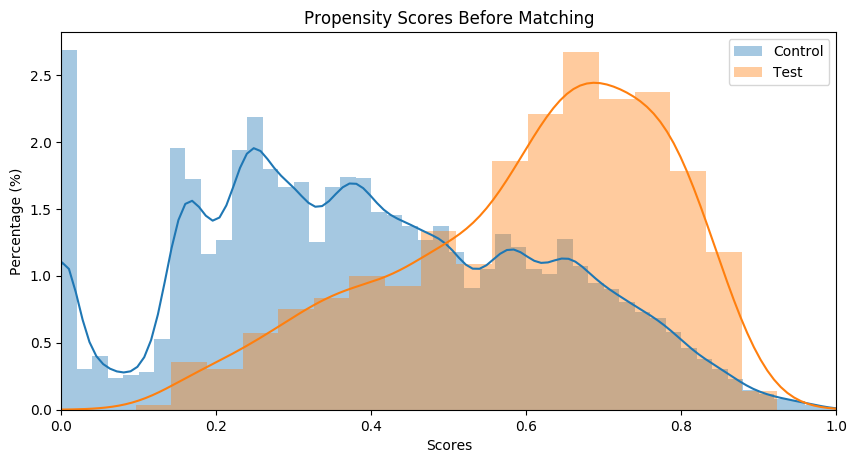

In [8]:
m.plot_scores()

The plot above demonstrates the separability present in our data. Test profiles have a much higher **propensity**, or estimated probability of defaulting given the features we isolated in the data.

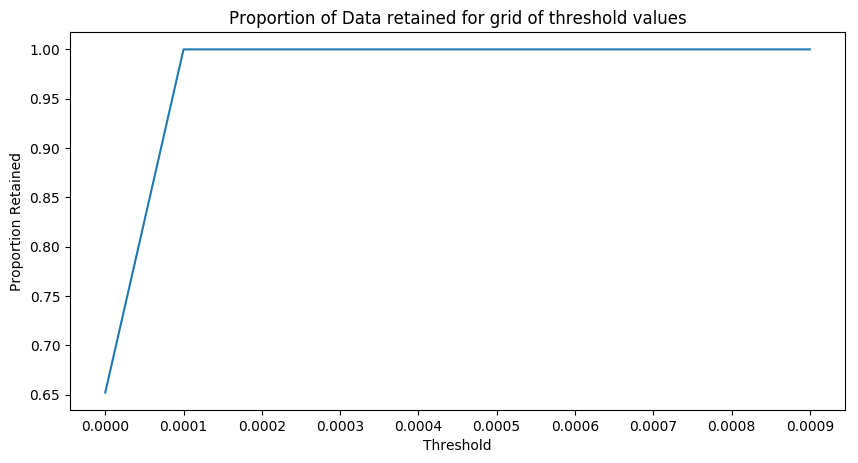

In [9]:
m.tune_threshold(method='random')

In [10]:
m.match(method="min", threshold=0.0001)

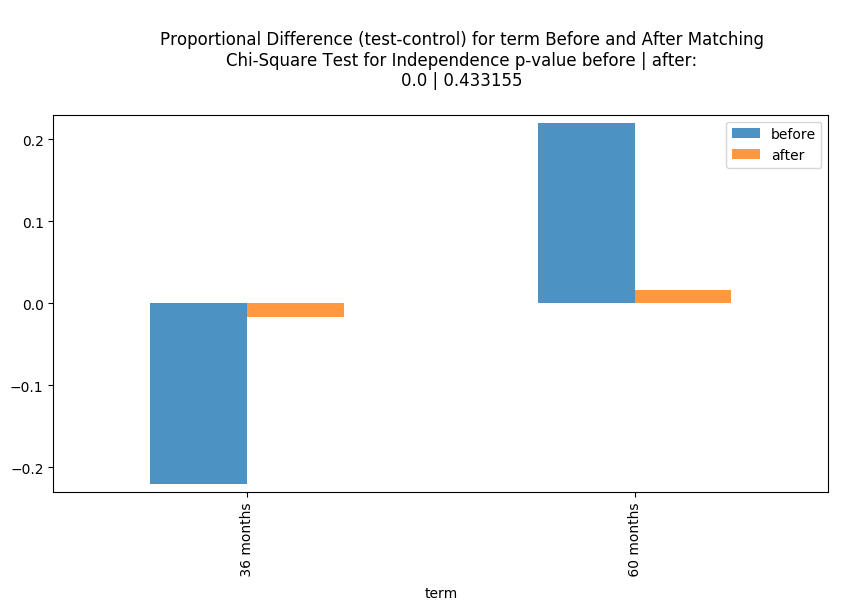

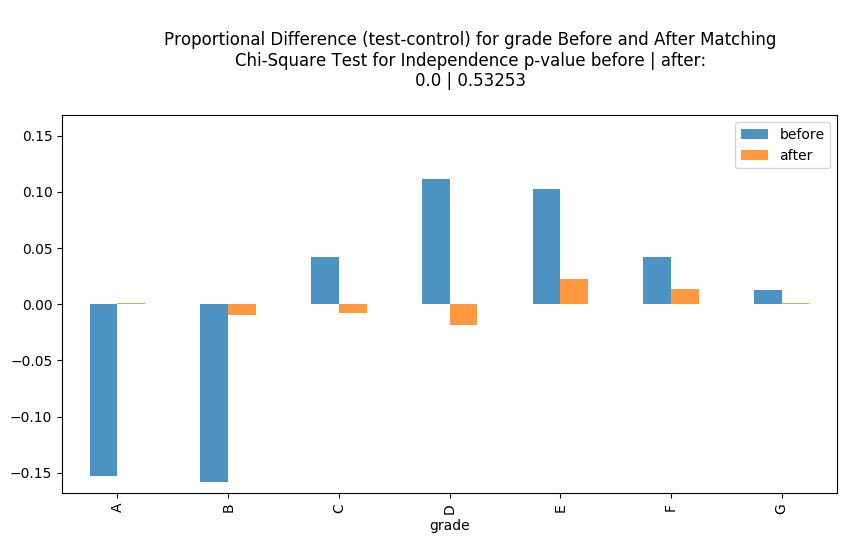

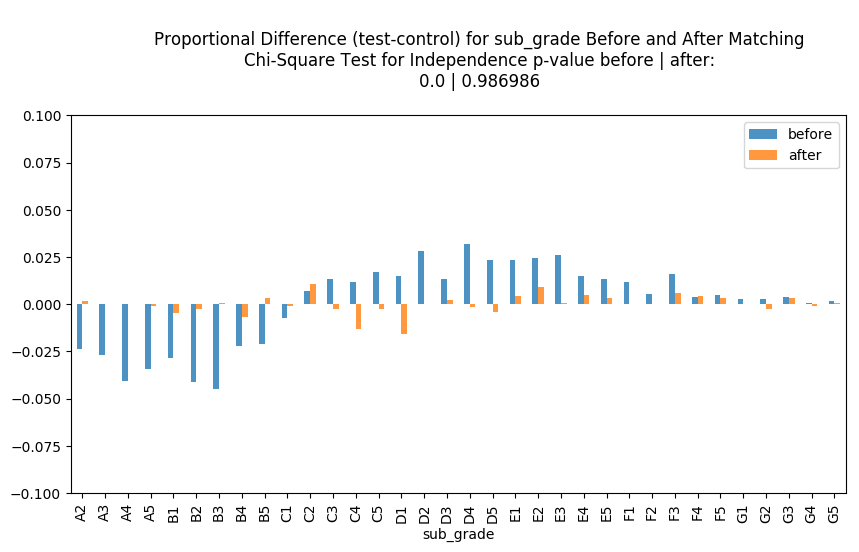

In [11]:
cd = m.compare_discrete(return_table=True)

In [12]:
cd

,var,before,after
0,term,0.0,0.433155
1,grade,0.0,0.532530
2,sub_grade,0.0,0.986986


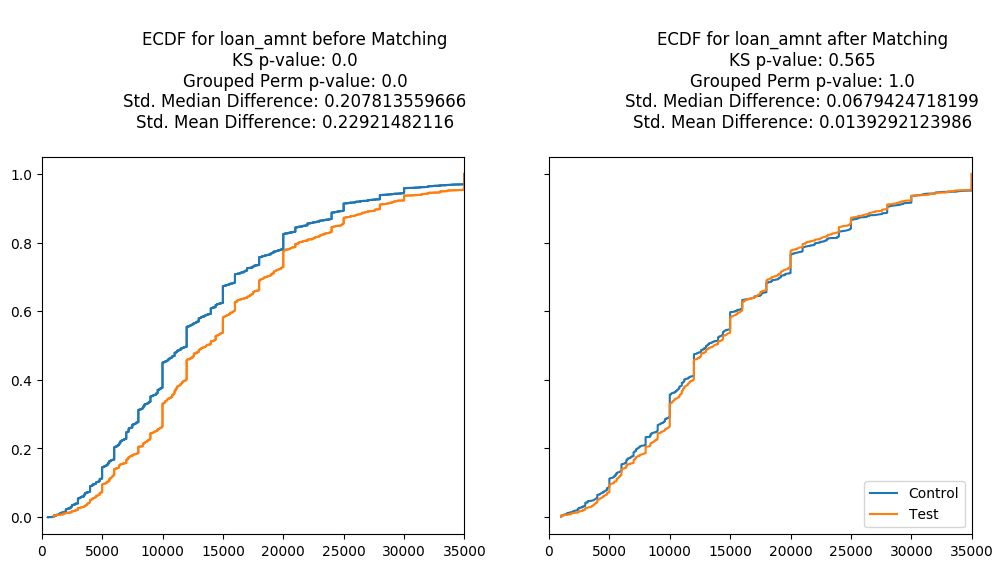

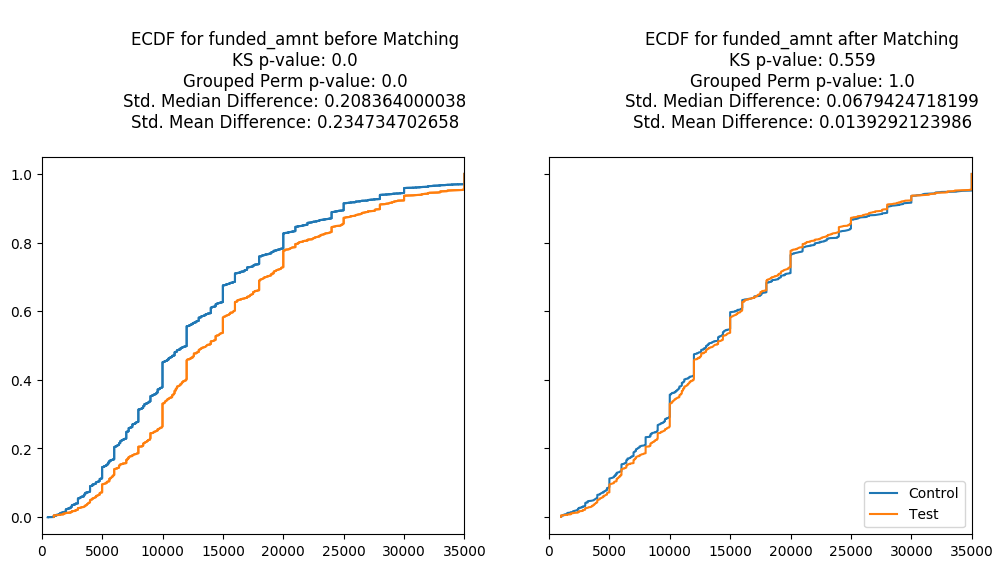

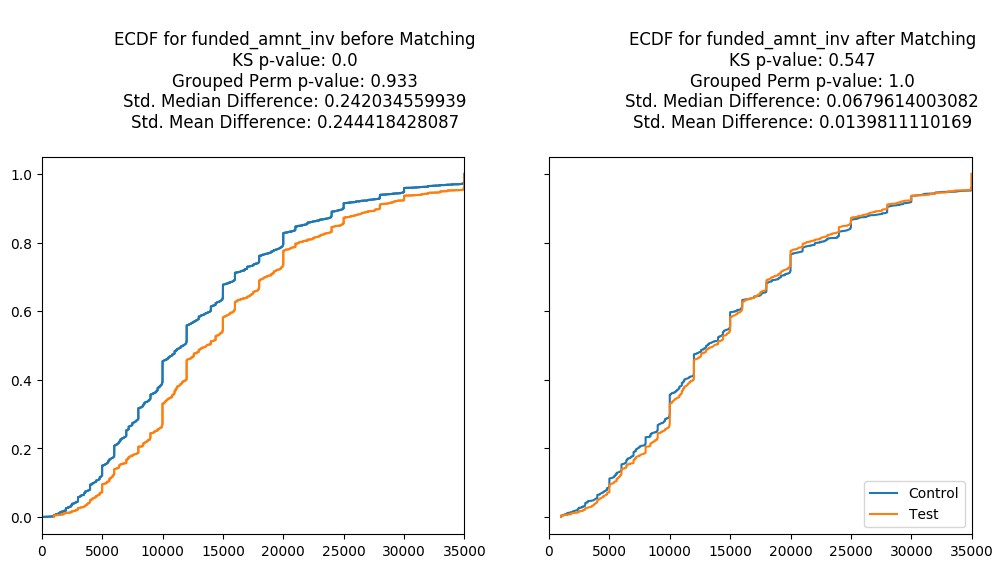

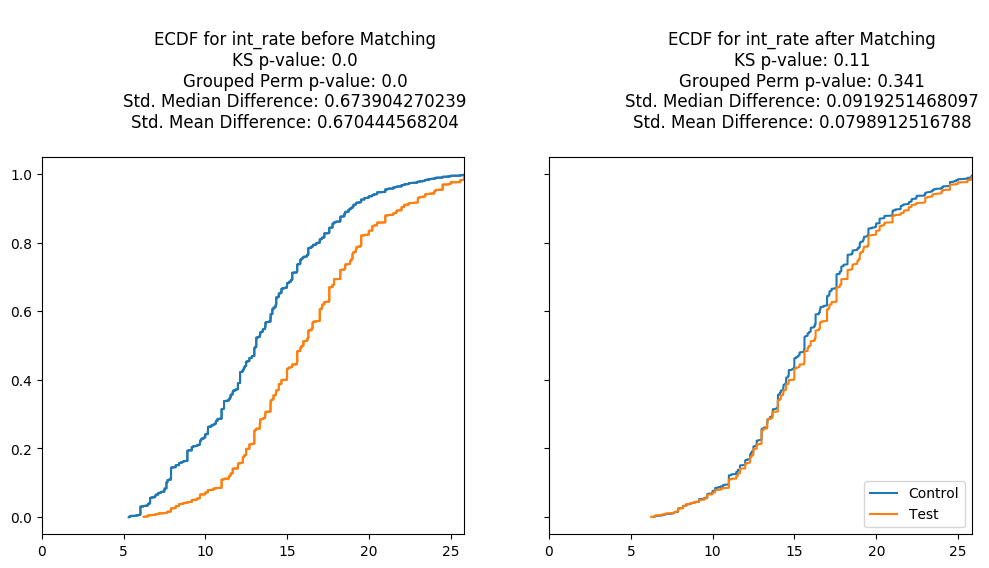

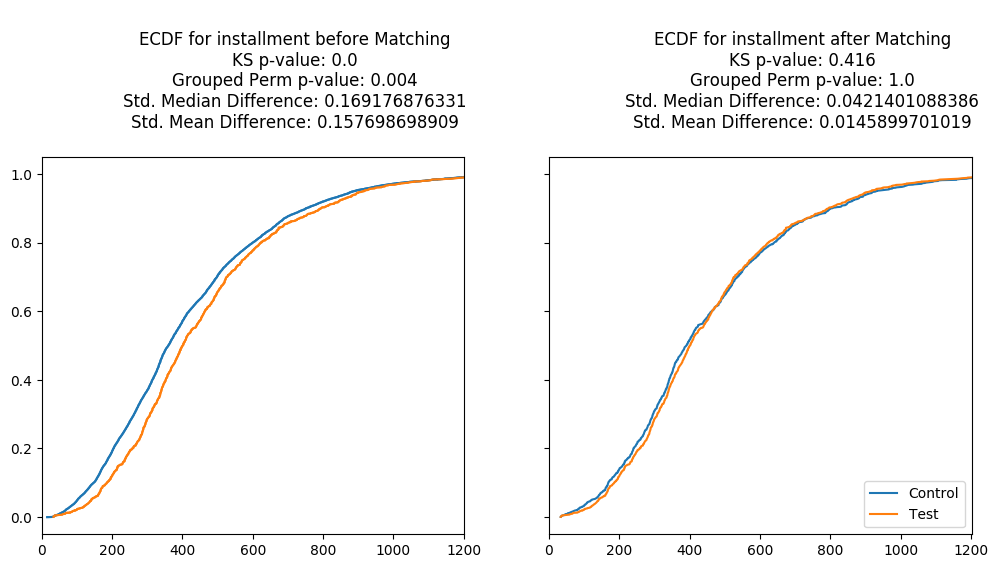

In [13]:
cc = m.compare_continuous(return_table=True)

In [14]:
cc

,var,ks_before,ks_after,perm_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,loan_amnt,0.0,0.565,0.000,1.000,0.207814,0.067942,0.229215,0.013929
1,funded_amnt,0.0,0.559,0.000,1.000,0.208364,0.067942,0.234735,0.013929
2,funded_amnt_inv,0.0,0.547,0.933,1.000,0.242035,0.067961,0.244418,0.013981
3,int_rate,0.0,0.110,0.000,0.341,0.673904,0.091925,0.670445,0.079891
4,installment,0.0,0.416,0.004,1.000,0.169177,0.042140,0.157699,0.014590


In [16]:
from pymatch.functions import chi2_distance